<a href="https://colab.research.google.com/github/cbertolasio/geospatial-datascience-quickstart/blob/main/Chapter5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 5: Nudging check-ins with Geofences

## Installations

The geospatial libraries are not pre installed in google colab as standard python library, therefore we need to install some libraries to use. Luckily this is an easy process. You can use either apt install or pip install. You can also create anaconda environment, but that is a bit complex so pip and apt are enough in our case to get the libraries we need. These are the libraries we need to install in this tutorial:

Gdal
Geopandas
Folium

The installation might take 1 minute.

In [ ]:
%%time 
!apt update
!apt upgrade

# GDAL
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install --upgrade geopandas --quiet
# Install descartes - Geopandas requirment
!pip install --upgrade descartes --quiet
# Install Folium for Geographic data visualization
!pip install folium --quiet
# Plotly Express
!pip install plotly_express

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Get:7 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Hit:8 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:9 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Hit:12 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:13 http

In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon


import matplotlib
import matplotlib.pyplot as plt 
import folium
from folium.plugins import TimestampedGeoJson
import os
import seaborn as sns

import json
import ast


import plotly 
import plotly.offline as py
import plotly.graph_objs as go
import plotly_express as px

plotly.__version__

'5.5.0'

## Data 

The dataset for this chapter is stored in the dropbox link. It is a valuable skill to learn how to access data on the web, so we will use WGET. WGET is great utility in accessing files from the web and supports different protocols. 

In [ ]:
!wget https://www.dropbox.com/s/ejev7z29lzirbo5/GPSTrajectory.zip
!unzip GPSTrajectory.zip

--2022-11-02 18:27:34--  https://www.dropbox.com/s/ejev7z29lzirbo5/GPSTrajectory.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.66.18, 2620:100:6023:18::a27d:4312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.66.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/ejev7z29lzirbo5/GPSTrajectory.zip [following]
--2022-11-02 18:27:34--  https://www.dropbox.com/s/raw/ejev7z29lzirbo5/GPSTrajectory.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc44e1b0b77c9d6a82d006823646.dl.dropboxusercontent.com/cd/0/inline/BwAI8LxSGfUWSkw9OG_4xcszH-X2OMamR_Bz2oz_9vV2xARvMRcJkqSEc3_OavxuLjLQNz7yfUX1ZjGMi5sLIFQ5x0CMdzvxAYbjpahEyB804gjDcJWDgeRUXZgSnrS8yXFu4puh1aZnjEUc79BjL2kNE4nKdCUSvnfnBvkYvGXcow/file# [following]
--2022-11-02 18:27:35--  https://uc44e1b0b77c9d6a82d006823646.dl.dropboxusercontent.com/cd/0/inline/BwAI8LxSGfUWSkw9OG_4xcszH-X2OMamR_Bz2oz_9vV2xARvMRcJkqSEc3_Oav

In [ ]:
trajectories = pd.read_csv('GPSTrajectory/go_track_trackspoints.csv')
trajectories.head()

,id,latitude,longitude,track_id,time
0,1,-10.939341,-37.062742,1,2014-09-13 07:24:32
1,2,-10.939341,-37.062742,1,2014-09-13 07:24:37
2,3,-10.939324,-37.062765,1,2014-09-13 07:24:42
3,4,-10.939211,-37.062843,1,2014-09-13 07:24:47
4,5,-10.938939,-37.062879,1,2014-09-13 07:24:53


In [ ]:
trajectories.shape

(18107, 5)

### Creat GeoDataFrame

In [ ]:
def create_gdf(df, lat, lon):
    """ Convert pandas dataframe into a Geopandas GeoDataFrame"""
    crs = {'init': 'epsg:4326'}
    geometry = [Point(xy) for xy in zip(df[lon], df[lat])]
    gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
    return gdf
traj_gdf =  create_gdf(trajectories, "latitude", "longitude")
traj_gdf.tail()

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



,id,latitude,longitude,track_id,time,geometry
18102,19565,-10.923722,-37.106579,38092,2016-01-19 13:01:01,POINT (-37.10658 -10.92372)
18103,19566,-10.923704,-37.106693,38092,2016-01-19 13:01:12,POINT (-37.10669 -10.92370)
18104,19567,-10.923715,-37.106688,38092,2016-01-19 13:01:24,POINT (-37.10669 -10.92371)
18105,19568,-10.923715,-37.106688,38092,2016-01-19 13:01:36,POINT (-37.10669 -10.92372)
18106,19569,-10.923716,-37.106688,38092,2016-01-19 13:01:47,POINT (-37.10669 -10.92372)


In [ ]:
aracaju_city_points = traj_gdf[(traj_gdf['latitude']<-10.80) & (traj_gdf['longitude']>-37.5)]


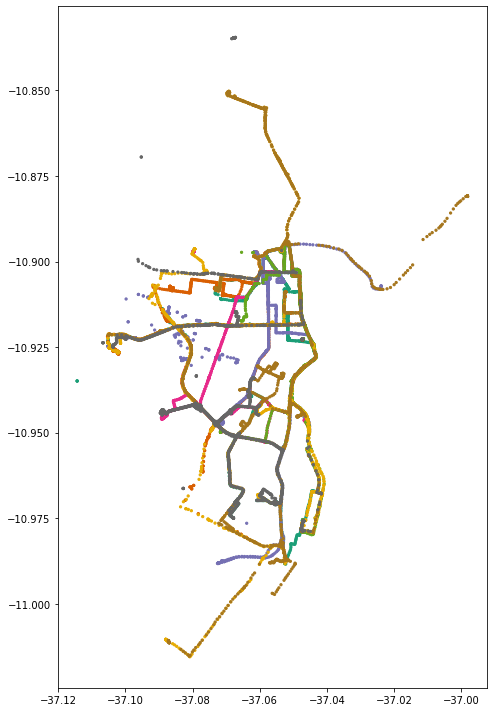

In [ ]:
fig, ax = plt.subplots(figsize=(8,10))
aracaju_city_points.plot(markersize=5, cmap='Dark2', ax=ax)
plt.tight_layout()

#plt.axis('off')
#plt.savefig('aracaju_trajectory.png')
plt.show()

## Geometry Revisited


### LineString Geometry

* Track_id 1 as an Example

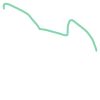

In [ ]:
# One Track 
track_id_1 = aracaju_city_points[aracaju_city_points['track_id']== 1]
line = LineString(track_id_1.geometry)
line

* The whole city tracks

In [ ]:
# Filter Track_id equal or more than 2 points
filtered_trackid = aracaju_city_points.groupby('track_id').filter(lambda x: len(x) >= 2)
filtered_trackid.shape, aracaju_city_points.shape

((16677, 6), (16687, 6))

In [ ]:
all_tracks = filtered_trackid.groupby(['track_id'])['geometry'].apply(lambda x: LineString(x.tolist()))
all_tracks[:5]

track_id
1    LINESTRING (-37.06274 -10.93934, -37.06274 -10...
2    LINESTRING (-37.06243 -10.93944, -37.06257 -10...
3    LINESTRING (-37.04829 -10.90316, -37.04826 -10...
4    LINESTRING (-37.05237 -10.90889, -37.05261 -10...
8    LINESTRING (-37.05234 -10.94378, -37.05244 -10...
Name: geometry, dtype: geometry

In [ ]:
all_tracks

track_id
1        LINESTRING (-37.06274 -10.93934, -37.06274 -10...
2        LINESTRING (-37.06243 -10.93944, -37.06257 -10...
3        LINESTRING (-37.04829 -10.90316, -37.04826 -10...
4        LINESTRING (-37.05237 -10.90889, -37.05261 -10...
8        LINESTRING (-37.05234 -10.94378, -37.05244 -10...
                               ...                        
38081    LINESTRING (-37.06292 -10.93895, -37.06292 -10...
38082    LINESTRING (-37.05929 -10.96777, -37.05939 -10...
38084    LINESTRING (-37.07892 -10.93352, -37.07887 -10...
38090    LINESTRING (-37.09528 -10.86945, -37.09528 -10...
38092    LINESTRING (-37.10658 -10.92372, -37.10669 -10...
Name: geometry, Length: 145, dtype: geometry

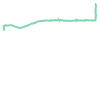

In [ ]:
all_tracks[4]

* Create GeoDataFrame from LineStrings

In [ ]:
gdf_lines_all = gpd.GeoDataFrame(all_tracks, geometry='geometry', crs = {'init':'epsg:4326'})

gdf_lines_all['track_id'] = gdf_lines_all.index
gdf_lines_all.reset_index(drop=True, inplace=True)

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



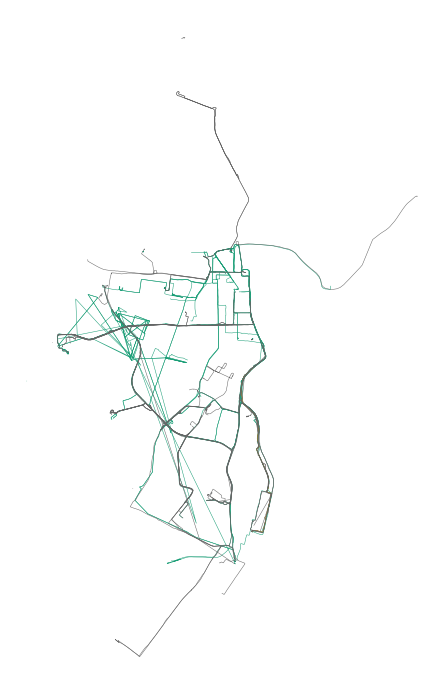

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
gdf_lines_all.plot(column='track_id',linewidth=0.5, cmap='Dark2', ax=ax)
plt.tight_layout()
# plt.savefig('trajectory_line.png')
# plt.axis('off')
plt.show()

### Polygon Geometries

In [ ]:
# Coordinates for a rectangle around aracaju city, Brazil
lats = [-10.813777, -11.002150, -11.070560,-10.878416]
lons = [-37.079790, -37.203427, -37.109280, -36.986931]

In [ ]:
# Create a Polygon Geometry
crs = {'init': 'epsg:4326'}
polygon_geometry = Polygon(zip(lons, lats))

In [ ]:
# Create a Polygon GeoDataFrame
polygon_gdf = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geometry]) 


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



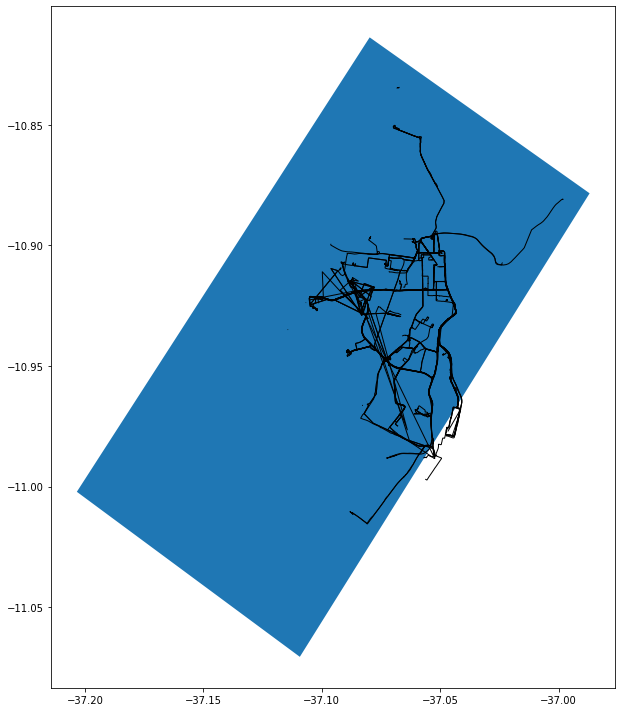

In [ ]:
# Plot Lines over Polygons 
fig, ax = plt.subplots(figsize=(10,10))
gdf_lines_all.plot(color='black',linewidth=1, ax=ax)
polygon_gdf.plot(ax=ax)
plt.tight_layout()
# plt.savefig('polygon_lines.png')
# plt.axis('off')
plt.show()

### Topology - Points in Polygon

* One Example track_id 1

In [ ]:
# Create buffer on Pointin track_id 1  (20 meter) 
buffer = track_id_1[track_id_1['id'] == 20].buffer(0.005)
buffer.reset_index(drop=True, inplace=True)
buffer_gdf = gpd.GeoDataFrame(buffer)
buffer_gdf.columns = ['geometry']
buffer_gdf

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning:

Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




,geometry
0,"POLYGON ((-37.05235 -10.94153, -37.05237 -10.9..."


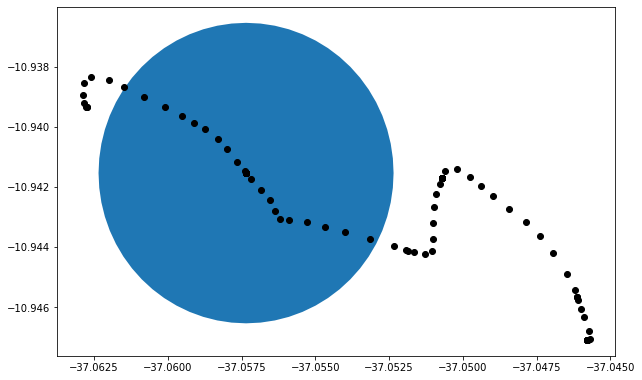

In [ ]:
# Plot track_id 1 points over the Buffer Polygon 
fig, ax = plt.subplots(figsize=(10,10))
buffer_gdf.plot(ax=ax)
track_id_1.plot(ax=ax, color='black')
#plt.tight_layout()
plt.savefig('polygon_lines.png')
#plt.axis('off')
plt.show()

In [ ]:
# Mask points in polygon -> returns True if inside polygon
pip_mask = track_id_1.within(buffer_gdf.loc[0, 'geometry'])
pip_mask.value_counts()

False    62
True     28
dtype: int64

In [ ]:
for i in pip_mask[:12]:
    if i == True:
        print('Inside the Buffer.')
    else:
        print('Outside the Buffer.')

Outside the Buffer.
Outside the Buffer.
Outside the Buffer.
Outside the Buffer.
Outside the Buffer.
Outside the Buffer.
Outside the Buffer.
Outside the Buffer.
Outside the Buffer.
Inside the Buffer.
Inside the Buffer.
Inside the Buffer.


In [ ]:
# Create PIP mask
pd.set_option('mode.chained_assignment', None)
track_id_1.loc[:,'pip_mask'] = pip_mask
track_id_1.head()

,id,latitude,longitude,track_id,time,geometry,pip_mask
0,1,-10.939341,-37.062742,1,2014-09-13 07:24:32,POINT (-37.06274 -10.93934),False
1,2,-10.939341,-37.062742,1,2014-09-13 07:24:37,POINT (-37.06274 -10.93934),False
2,3,-10.939324,-37.062765,1,2014-09-13 07:24:42,POINT (-37.06276 -10.93932),False
3,4,-10.939211,-37.062843,1,2014-09-13 07:24:47,POINT (-37.06284 -10.93921),False
4,5,-10.938939,-37.062879,1,2014-09-13 07:24:53,POINT (-37.06288 -10.93894),False


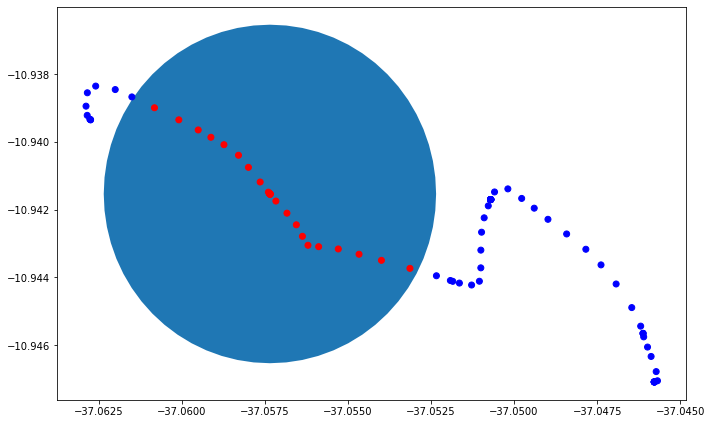

In [ ]:
# Plot track_id 1 points over the Buffer Polygon 
fig, ax = plt.subplots(figsize=(10,10))
buffer_gdf.plot(ax=ax)
track_id_1.plot(ax=ax, column='pip_mask', cmap='bwr')
plt.tight_layout()
plt.savefig('pipmask_buffer.png')
#plt.axis('off')
plt.show()

## Geofencing with Plotly

In [ ]:
!wget https://www.dropbox.com/s/h0bf2jlaftynu18/geofence_polygons.zip
!unzip geofence_polygons.zip

--2022-11-02 19:19:30--  https://www.dropbox.com/s/h0bf2jlaftynu18/geofence_polygons.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:6023:18::a27d:4312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/h0bf2jlaftynu18/geofence_polygons.zip [following]
--2022-11-02 19:19:31--  https://www.dropbox.com/s/raw/h0bf2jlaftynu18/geofence_polygons.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca781d554e8f8ad25a6cf7c2778.dl.dropboxusercontent.com/cd/0/inline/BwC3eyEdVgEGg_jxLcq4xJvf8SCNKYlnOeQsmyDWkVOev9ToGL2IQiI-JW4J_BGN-in7Rx8FvWbJ7XDxnPfSnsiZ-qSKt4ptAHFoTPRmWUVeoMYU4YELfxbq6knMPV1atZRo1IVdVqnHiBA7IXmIi9GCLHaPd-XclHFw5D8QcT-Otg/file# [following]
--2022-11-02 19:19:31--  https://uca781d554e8f8ad25a6cf7c2778.dl.dropboxusercontent.com/cd/0/inline/BwC3eyEdVgEGg_jxLcq4xJvf8SCNKYlnOeQsmyDWkVOev9ToGL2I

In [ ]:
geofence_polygons = gpd.read_file('geofence_polygons.gpkg')
geofence_polygons

,id,name,geometry
0,1,Airport,"MULTIPOLYGON (((-37.08070 -10.99097, -37.09384..."
1,2,Beach,"MULTIPOLYGON (((-37.05289 -10.98570, -37.05342..."
2,3,Center,"MULTIPOLYGON (((-37.05482 -10.90604, -37.04810..."


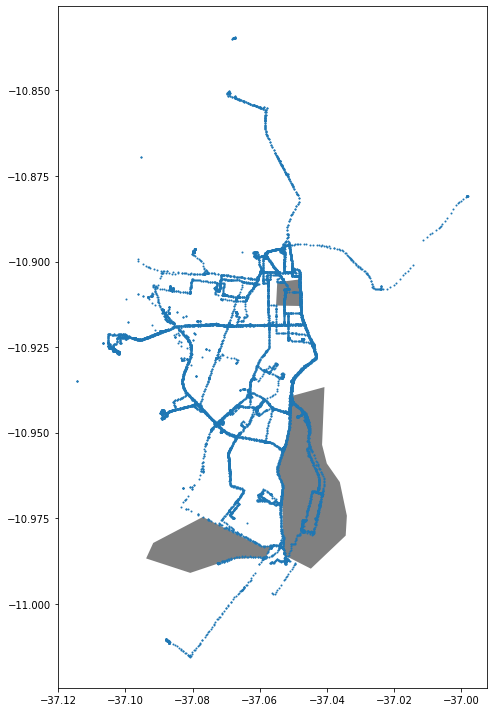

In [ ]:
# Plot filtered_tracid points over geofence polygons 
fig, ax = plt.subplots(figsize=(10,10))
geofence_polygons.plot(ax=ax, color='gray')
filtered_trackid.plot(ax=ax, markersize=1)
plt.tight_layout()
plt.savefig('geofence_polygons.png')
#plt.axis('off')
plt.show()

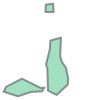

In [ ]:
# Create mask
mask = (geofence_polygons.loc[0, 'geometry'])| (geofence_polygons.loc[1, 'geometry']) |(geofence_polygons.loc[2, 'geometry'])
mask

In [ ]:
# Get points within the masks
pip_mask_geofence = filtered_trackid.within(mask)
pip_mask_geofence.value_counts()

False    14420
True      2257
dtype: int64

In [ ]:
#Create PIP mask
filtered_trackid.loc[:,'geofence'] = pip_mask_geofence

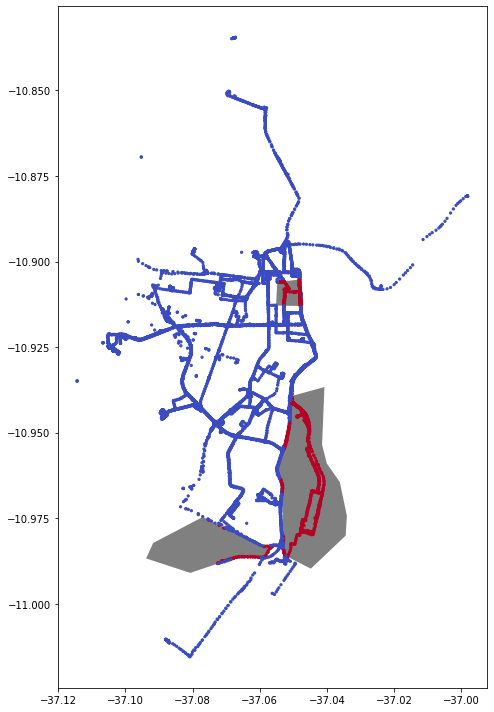

In [ ]:
# Plot filtered track_id 1 points over the Geofence Polygons
fig, ax = plt.subplots(figsize=(10,10))
geofence_polygons.plot(ax=ax, color='gray')
#filtered_trackid[filtered_trackid['pip_mask_geofence'] == True].plot(ax=ax, color='red')
filtered_trackid.plot(ax=ax, markersize=5, column='geofence', cmap='coolwarm')

plt.tight_layout()
plt.savefig('polygon_lines.png')
#plt.axis('off')
plt.show()

In [ ]:
# Replace True with In and False with Out
filtered_trackid['geofence'] = filtered_trackid['geofence'].replace({True: 'In', False: 'Out'})
filtered_trackid.head()

,id,latitude,longitude,track_id,time,geometry,geofence
0,1,-10.939341,-37.062742,1,2014-09-13 07:24:32,POINT (-37.06274 -10.93934),Out
1,2,-10.939341,-37.062742,1,2014-09-13 07:24:37,POINT (-37.06274 -10.93934),Out
2,3,-10.939324,-37.062765,1,2014-09-13 07:24:42,POINT (-37.06276 -10.93932),Out
3,4,-10.939211,-37.062843,1,2014-09-13 07:24:47,POINT (-37.06284 -10.93921),Out
4,5,-10.938939,-37.062879,1,2014-09-13 07:24:53,POINT (-37.06288 -10.93894),Out


Get your token from Mapbox API https://www.mapbox.com 

Register if you do not have Mapbox Account and then go to Account. Under Access tokens click on Create Token and copy your token here.

In [85]:
# Function to display plotly images in Google colaboratory 
#Source : https://colab.research.google.com/drive/14oudHx5e5r7hm1QcbZ24FVHXgVPD0k8f
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))
plotly.offline.init_notebook_mode(connected=True)

In [87]:
px.set_mapbox_access_token("pk.eyJ1IjoiY2JlcnRvbGFzaW8iLCJhIjoiY2tvOHI2Y2g3MWpjNDJ1b24zcWJhdzZyayJ9.Yrq_gnbh3vBoymhtNsXYQw")
configure_plotly_browser_state()
px.scatter_mapbox(filtered_trackid.sample(500), lat="latitude", lon="longitude", color="geofence", size='track_id' ,
                   size_max=12, zoom=12, width=1200, height=800)


* Animate points with time ( Geofencing --> In/Out depending on the position of the track)

In [88]:
configure_plotly_browser_state()
px.scatter_mapbox(filtered_trackid[:100], 
                  lat="latitude", 
                  lon="longitude", 
                  color="geofence", 
                  size='track_id', 
                  animation_frame='time',
                  size_max=15, zoom=12)

# END